## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
* Split data into training and test datasets
    * Normalizing
* Building the LSTM model
  * Regressor
  * Sequence
    * Normalization by window of days (steps).
* Testing the model
* Conclusions

### Import Libraries

In [9]:
import os
import io
import random
import requests
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [18]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    url = "https://www.coingecko.com/price_charts/export/279/eur.csv"
    content = requests.get(url).content
    data = pd.read_csv(io.StringIO(content.decode('utf-8')))

    #save it
    data.to_csv(datafile)

In [19]:
data = pd.read_csv(datafile)

#print a random sample
data.iloc[random.randint(0, data.shape[0])]

Unnamed: 0                          987
snapped_at      2018-04-21 00:00:00 UTC
price                           479.404
market_cap                  4.74342e+10
total_volume                1.19966e+09
Name: 987, dtype: object

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 5 columns):
Unnamed: 0      1030 non-null int64
snapped_at      1030 non-null object
price           1030 non-null float64
market_cap      1029 non-null float64
total_volume    1030 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 40.3+ KB


Here we can see that every sample is defined by the day in a date format, the current price, the capital market and the total volume of transactions that have been done that day.

At first glance, they are good indicators so all of them will be used as features.

In [21]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [22]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [23]:
features = ['price', 'market_cap', 'total_volume']

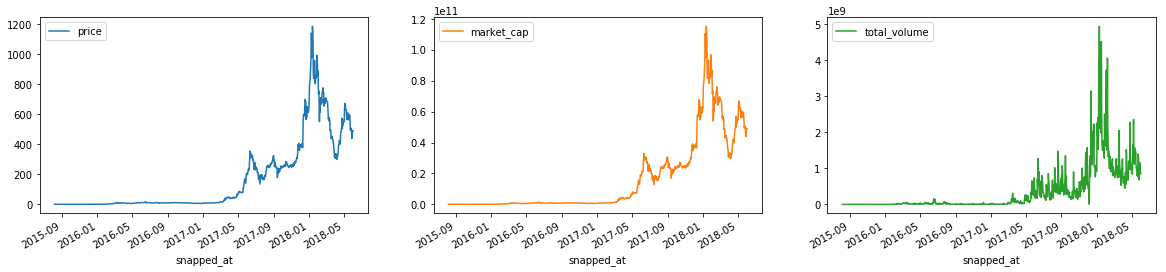

In [24]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

In [25]:
data.iloc[0:10]

,Unnamed: 0,price,market_cap,total_volume
snapped_at,,,,
2015-08-07,0,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1,1.175306,7.095505e+07,3.250759e+05
2015-08-10,2,0.624116,3.772033e+07,3.634980e+05
2015-08-11,3,0.966607,5.844581e+07,1.375588e+06
2015-08-12,4,1.126292,6.813006e+07,1.858814e+06
2015-08-13,5,1.636673,9.904778e+07,3.927292e+06
2015-08-14,6,1.643557,9.951063e+07,3.920484e+06
2015-08-15,7,1.505036,9.116528e+07,2.269451e+06
2015-08-16,8,1.329391,8.055977e+07,2.730304e+06


---
### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [26]:
#check
'2015-08-09 00:00:00' in data.index

False

In [27]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

Now, the index is completed but the inexistent samples must be filled out.

#### Find NaN and Fix it

In [28]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [29]:
#check
data.loc['2015-08-09 00:00:00']

Unnamed: 0      1.500000e+00
price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [30]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

Unnamed: 0      0
price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

Now we need to include a new feature which will define the closed price for every sample. Ethereum market is always open so we can forget about weekends and use directly the open price of the next sample.

Afterwards the model will use this feature as the target since it's the value we try to predict.

The following script will help us with that.

In [31]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,Unnamed: 0,price,market_cap,total_volume,closed_price
2018-05-29,1025.0,439.929286,4.387317e+10,1.160172e+09,486.891527
2018-05-30,1026.0,486.891527,4.856664e+10,1.130360e+09,475.975318
2018-05-31,1027.0,475.975318,4.748764e+10,9.230434e+08,488.831828
2018-06-01,1028.0,488.831828,4.878041e+10,8.694144e+08,491.781091
2018-06-02,1029.0,491.781091,4.908483e+10,8.475091e+08,NaN


In [32]:
#Delete last because we don't know still the closed price 
data = data.drop(data.index[len(data)-1])

----
### Split Data into Training and Test Datasets

In [33]:
#X_train, X_test, y_train, y_test = train_test_split(data[features], 
#                                                    data.closed_price, 
#                                                    test_size=0.20,
#                                                    shuffle=False,
#                                                    random_state=42)

#80% for training
split = round(len(data)*0.8)
data_train, data_test = data[:split].copy(), data[split:].copy()

In [34]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 824
Size data_test: 206


#### Normalizing

Take care of this because we __don't know if the future values are in the range__. For this reason we'll __fit the scaler using only the training data__ and not the testing data.

In [35]:
#Scale the data
scaler = MinMaxScaler()

data_train[data.columns] = scaler.fit_transform(data_train[data.columns])
data_test[data.columns] = scaler.transform(data_test[data.columns])

data_test.describe()

,Unnamed: 0,price,market_cap,total_volume,closed_price
count,206.000000,206.000000,206.000000,206.000000,206.000000
mean,1.125912,1.622630,1.714040,0.861047,1.625705
std,0.072520,0.568058,0.595651,0.524619,0.565007
min,1.001217,0.725226,0.750763,0.003342,0.725226
25%,1.063564,1.134561,1.199128,0.547398,1.144973
50%,1.125912,1.611832,1.714118,0.704574,1.611832
75%,1.188260,1.926639,2.039763,1.024710,1.926639
max,1.250608,3.336560,3.497460,3.341789,3.336560


---
## Building the Model

### Check Tensorflow and GPU

In [36]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


### Regressor model

* 1 step and 3 features

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

X_train = data_train[features].values.reshape((data_train.shape[0], 1, 3))
y_train = data_train.closed_price.values

X_test = data_test[features].values.reshape((data_test.shape[0], 1, 3))
y_test = data_test.closed_price.values


Using TensorFlow backend.


In [38]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(824, 1, 3)
(824,)
(206, 1, 3)
(206,)


In [39]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

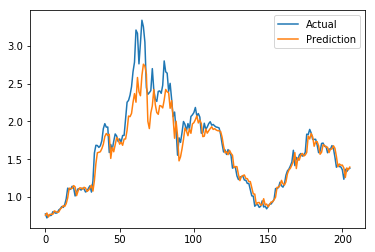

In [40]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

### Sequence model

* 7 steps and 3 features

In [41]:
'''
Helper function to transform the dataset to
shapes defined by 7 steps and 3 features
'''
def prepare_sequence(data):
    sequence = []
    sequence_size = 7
    samples = 0
    for i in range(0, data.shape[0] - sequence_size + 1):
        sequence.append(data[i:i+7])
        samples += 1
    return np.concatenate(sequence).reshape((samples, sequence_size, data.shape[1]))

prepare_sequence(data[features]).shape

(1024, 7, 3)

In [43]:
#getting (samples, steps, features)
X_train = prepare_sequence(data_train[features])
X_test = prepare_sequence(data_test[features])

#closed price to predict will be the last price of the last step in sequence
#for this reason the closed price of sequence [0:7] will be [6]
y_train = data_train.iloc[-len(X_train):].closed_price.values
y_test = data_test.iloc[-len(X_test):].closed_price.values

y_train = data_train.iloc[6:].closed_price.values
y_test = data_test.iloc[6:].closed_price.values

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(818, 7, 3)
(818,)
(200, 7, 3)
(200,)


In [45]:
model = Sequential()
model.add(LSTM(32, input_shape=(7, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

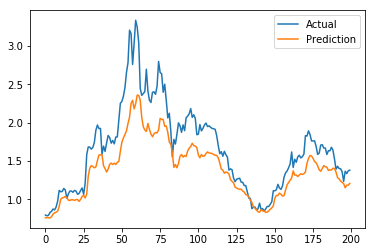

In [46]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

----

### ⇩ __NORMALIZE A WINDOW OF STEPS BY THE RATE OF CHANGE__ ⇩
The neural network is not able to get good predictions for that data that has not seen before. For that reason we can find day that are not well fitted. This problem is related to the __'out-of-scale'__ data inputs.

Thinking that the batch size is a window of days that defines how the neural network learns, one idea is to normalize the window by the last sample. On this way we'll be able to keep almost all data in the same scale.

In [47]:
def print_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    print("mean:{:.3f} std:{:.3f}".format(mean, std))

In [55]:
def window_normalization(data, window_size):
    y = np.empty_like(data, dtype='float64')
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data))
        y[i:j] = data[i:j]/np.abs(data[j-1])
        print_mean_std(y[i:j])
        
    return y

def window_desnormalization(data, window_size):
    y = np.empty_like(data, dtype='float64')
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data))
        y[i:j] = data[i:j]*np.abs(data[j-1])
        
    return y

In [49]:
#testing the function
a = np.array([[1, 1, 1], [2, 2, 2], [2, 2, 2], [8, 8, 8]])
expected_result = np.array([[0.5, 0.5, 0.5], [1, 1, 1], [0.25, 0.25, 0.25], [1, 1, 1]])
assert ( np.array_equal(window_normalization(a, 2), expected_result) )

mean:0.750 std:0.250
mean:0.625 std:0.375


In [50]:
data.index[-1].strftime("%d-%m-%Y")

'01-06-2018'

In [51]:
window_size=32

X_train = data_train[features].values
y_train = data_train.closed_price.values

X_train = window_normalization(X_train, window_size)
y_train = window_normalization(y_train, window_size)

#getting (samples, steps, features)
X_train = prepare_sequence(X_train)
y_train = y_train[6:]

mean:1.697 std:1.866
mean:1.589 std:0.886
mean:0.831 std:0.673
mean:0.741 std:0.281
mean:0.679 std:0.355
mean:0.547 std:0.441
mean:0.717 std:0.331
mean:1.072 std:0.328
mean:0.600 std:0.230
mean:0.885 std:0.415
mean:0.668 std:0.323
mean:2.864 std:4.536
mean:1.280 std:1.032
mean:0.935 std:0.265
mean:1.289 std:0.613
mean:1.079 std:0.750
mean:1.043 std:0.531
mean:0.756 std:0.539
mean:0.958 std:0.597
mean:0.734 std:0.451
mean:0.961 std:0.801
mean:1.372 std:0.473
mean:0.865 std:0.406
mean:1.102 std:0.312
mean:0.946 std:0.481
mean:0.959 std:0.210
mean:1.075 std:0.264
mean:1.938 std:0.816
mean:0.876 std:0.586
mean:0.921 std:0.113
mean:0.725 std:0.116
mean:0.479 std:0.272
mean:0.796 std:0.310
mean:1.193 std:0.165
mean:0.679 std:0.144
mean:1.113 std:0.173
mean:0.932 std:0.103
mean:1.016 std:0.096
mean:0.948 std:0.067
mean:1.063 std:0.047
mean:1.226 std:0.076
mean:0.976 std:0.057
mean:0.958 std:0.059
mean:0.689 std:0.141
mean:0.890 std:0.273
mean:0.696 std:0.193
mean:0.598 std:0.230
mean:1.599 st

In [52]:
model = Sequential()
model.add(LSTM(32, input_shape=(7,3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=window_size, verbose=0)

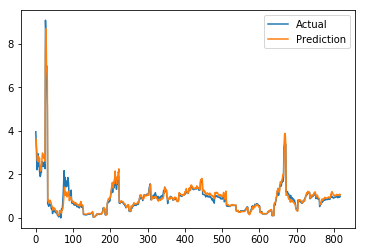

In [56]:
pred = model.predict(X_train)
plt.plot(window_desnormalization(y_train, window_size), label='Actual')
plt.plot(window_desnormalization(pred, window_size), label='Prediction')
plt.legend()

---
## Testing the Model

Seeing the last results our best chance of accurate predictions is to use:

* LSTM sequence by 7 steps and 3 features
* Window normalization

mean:0.798 std:0.239
mean:0.531 std:0.207
mean:1.306 std:0.397
mean:1.239 std:0.222
mean:0.921 std:0.254
mean:1.073 std:0.275
mean:1.081 std:0.161
mean:0.907 std:0.140
mean:0.725 std:0.170
mean:1.261 std:0.226
mean:1.329 std:0.150
mean:0.922 std:0.140
mean:0.967 std:0.113
mean:1.043 std:0.091


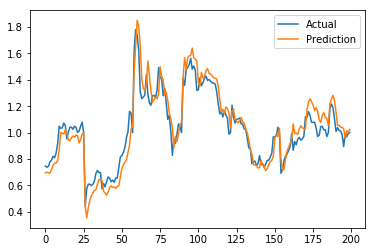

In [54]:
X_test = data_test[features].values
y_test = data_test.closed_price.values

X_test = window_normalization(X_test, window_size)
y_test = window_normalization(y_test, window_size)

#getting (samples, steps, features)
X_test = prepare_sequence(X_test)
y_test = y_test[6:]

pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

## Conclusions


Log:

1. Added new method 'print_mean_std' to detect the stability of the data within the window size.
    * Would it affect the formula which is being used for window normalization?